# Functions

In [57]:
# Import statements

import h5py
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


from scipy.signal import savgol_filter


In [2]:

# Import single sleap file for analysis 

# filename = '/Users/ellasay/Google Drive/My Drive/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'
def import_single_slp(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]

    print("===filename===")
    print(filename)
    print()

    print("===HDF5 datasets===")
    print(dset_names)
    print()

    print("===locations data shape===")
    print(locations.shape)
    print()

    print("===nodes===")
    for i, name in enumerate(node_names):
        print(f"{i}: {name}")
    print()

# Modified to apply to whole directory of h5 files

def import_h5_dir(directory):
    # Get a list of all .h5 files in the directory
    h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]

    # Initialize an empty list to store data for the DataFrame
    data = []

    for h5_file in h5_files:
        filename = os.path.join(directory, h5_file)
        
        # Open and process the .h5 file
        with h5py.File(filename, "r") as f:
            # dset_names = list(f.keys())
            locations = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]
            
            # Append the data to the list
            data.append({
                'file_name': h5_file, \
                # 'dataset_names': dset_names,
                'location shape': locations.shape,
                'locations': locations
                #'node_names': node_names
            })
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

# Fill in missing values (NaN vavlues due to tracking errors)
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

NOSE_INDEX = 0
LEFTEAR_INDEX = 1
RIGHTEAR_INDEX = 2
TORSO_INDEX = 3
LEFT_HINDPAW = 4
RIGHT_HINDPAW = 5
TAILBASE = 6

def store_nodes(row):
    nodes = {
        'nose':NOSE_INDEX,
        'leftear': LEFTEAR_INDEX,
        'rightear':RIGHTEAR_INDEX,
        'torso': TORSO_INDEX,
        'left_hindpaw': LEFT_HINDPAW,
        'right_hindpaw':RIGHT_HINDPAW,
        'tailbase':TAILBASE
    }
    location_dict = {}
    locations = row['locations']

    for node, index in nodes.items():

        x_coords = locations[:,index,0,0]
        y_coords = locations[:,index,1,0]
        location_dict[f'{node}_x'] = x_coords
        location_dict[f'{node}_y'] = y_coords
        # node_loc = locations[:,index,:,:].reshape(-1)
        # location_dict[node] = node_loc

    return pd.Series(location_dict)


In [4]:
frame_count, node_count, _, instance_count = location_dict.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

NameError: name 'location_dict' is not defined

# Import dir of .slp files

In [66]:
directory_path = '/Volumes/groups/giocomo/esay/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'  # Replace with your directory path
df = import_single_slp(directory_path)
print(df)

===filename===
/Volumes/groups/giocomo/esay/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(36292, 7, 2, 1)

===nodes===
0: Nose
1: Left_ear
2: Right_ear
3: Torso
4: Left_hindpaw
5: Right_hindpaw
6: Tailbase

None


In [5]:
directory_path = '/Users/ellasay/Google Drive/My Drive/can_project/behavior/1.SLEAP/h5/Archive'  # Replace with your directory path
df = import_h5_dir(directory_path)
print(df)

                                           file_name    location shape  \
0  day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_r...  (36292, 7, 2, 1)   
1  day4_s3_unrestricted_novel_diff_sex.mp4.000_da...  (36640, 7, 2, 1)   
2  day1_unrestricted_familiar.mp4.000_day1_unrest...  (37778, 7, 2, 1)   
3  day2_s2_restricted_familiar.mp4.000_day2_s2_re...  (20067, 7, 2, 1)   

                                           locations  
0  [[[[616.30926514], [183.65576172]], [[627.9155...  
1  [[[[311.64328003], [239.91603088]], [[300.1182...  
2  [[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...  
3  [[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...  


# Fill in NaN values

In [6]:
print(df['location shape'])
print(df.shape[0])

0    (36292, 7, 2, 1)
1    (36640, 7, 2, 1)
2    (37778, 7, 2, 1)
3    (20067, 7, 2, 1)
Name: location shape, dtype: object
4


In [7]:
df['locations'] = df['locations'].apply(fill_missing) # fill_missing is NOT a vectorized function (cannot apply to whole column)

print(df)

                                           file_name    location shape  \
0  day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_r...  (36292, 7, 2, 1)   
1  day4_s3_unrestricted_novel_diff_sex.mp4.000_da...  (36640, 7, 2, 1)   
2  day1_unrestricted_familiar.mp4.000_day1_unrest...  (37778, 7, 2, 1)   
3  day2_s2_restricted_familiar.mp4.000_day2_s2_re...  (20067, 7, 2, 1)   

                                           locations  
0  [[[[616.30926514], [183.65576172]], [[627.9155...  
1  [[[[311.64328003], [239.91603088]], [[300.1182...  
2  [[[[268.79519653], [360.16540527]], [[539.6796...  
3  [[[[400.39141846], [148.06048584]], [[319.8176...  


# store node locations

In [25]:
df = df.join(df.apply(store_nodes,axis=1))


ValueError: columns overlap but no suffix specified: Index(['nose_x', 'nose_y', 'leftear_x', 'leftear_y', 'rightear_x',
       'rightear_y', 'torso_x', 'torso_y', 'left_hindpaw_x', 'left_hindpaw_y',
       'right_hindpaw_x', 'right_hindpaw_y', 'tailbase_x', 'tailbase_y'],
      dtype='object')

In [26]:
print(df)
print(df.shape)

                                           file_name    location shape  \
0  day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_r...  (36292, 7, 2, 1)   
1  day4_s3_unrestricted_novel_diff_sex.mp4.000_da...  (36640, 7, 2, 1)   
2  day1_unrestricted_familiar.mp4.000_day1_unrest...  (37778, 7, 2, 1)   
3  day2_s2_restricted_familiar.mp4.000_day2_s2_re...  (20067, 7, 2, 1)   

                                           locations  \
0  [[[[616.30926514], [183.65576172]], [[627.9155...   
1  [[[[311.64328003], [239.91603088]], [[300.1182...   
2  [[[[268.79519653], [360.16540527]], [[539.6796...   
3  [[[[400.39141846], [148.06048584]], [[319.8176...   

                                              nose_x  \
0  [616.3092651367188, 616.2351684570312, 616.166...   
1  [311.6432800292969, 311.6419677734375, 311.717...   
2  [268.7951965332031, 268.7951965332031, 268.795...   
3  [400.39141845703125, 400.39141845703125, 400.3...   

                                              nose_y  \
0  [183.655

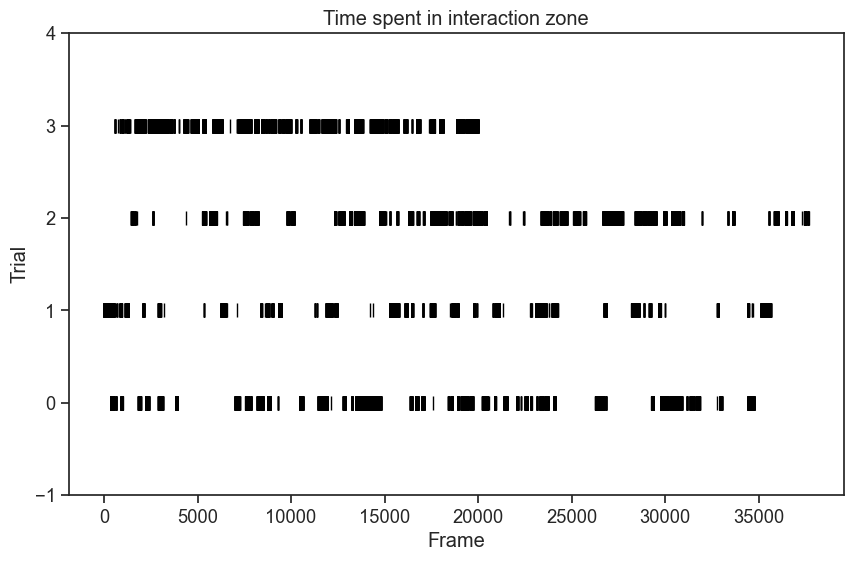

In [80]:
# quantify amount of time spent on the sides vs the middle

# Initialize an empty list to store frame indices for each trial
filtered_frames = []


for i, row in df.iterrows():
    nose_x = np.array(row['nose_x']).astype(float)
    nose_y = np.array(row['nose_y']).astype(float)
    
    # interaction zone x = [300,400] y=[200,300]
    int_zone = (nose_x >= 300) & (nose_x <= 400) & (nose_y >= 200) & (nose_y <= 300)
    frame_indices = np.where(int_zone)[0]  

    filtered_frames.append(frame_indices)

# plot raster
fig, ax = plt.subplots(figsize=(10, 6))

for i, frames in enumerate(filtered_frames):
    ax.plot(frames, np.ones_like(frames) * i, '|', color='black', markersize=10)  # Raster points for each trial

# Labeling the plot
ax.set_title('Time spent in interaction zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
ax.set_ylim(-1, len(filtered_frames))

plt.show()





In [95]:
i=0
for i in range(0,3):
    int_frames = len(filtered_frames[i])
    total_frames = df["location shape"].iloc[i][0]
    int_perc = (int_frames/total_frames)*100
    print(int_perc)


14.8930893860906
10.74235807860262
17.45725025146911


# Analysis

In [12]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [28]:
df['nose_x']

0    [616.3092651367188, 616.2351684570312, 616.166...
1    [311.6432800292969, 311.6419677734375, 311.717...
2    [268.7951965332031, 268.7951965332031, 268.795...
3    [400.39141845703125, 400.39141845703125, 400.3...
Name: nose_x, dtype: object

Text(0.5, 1.0, 'Nose tracks')

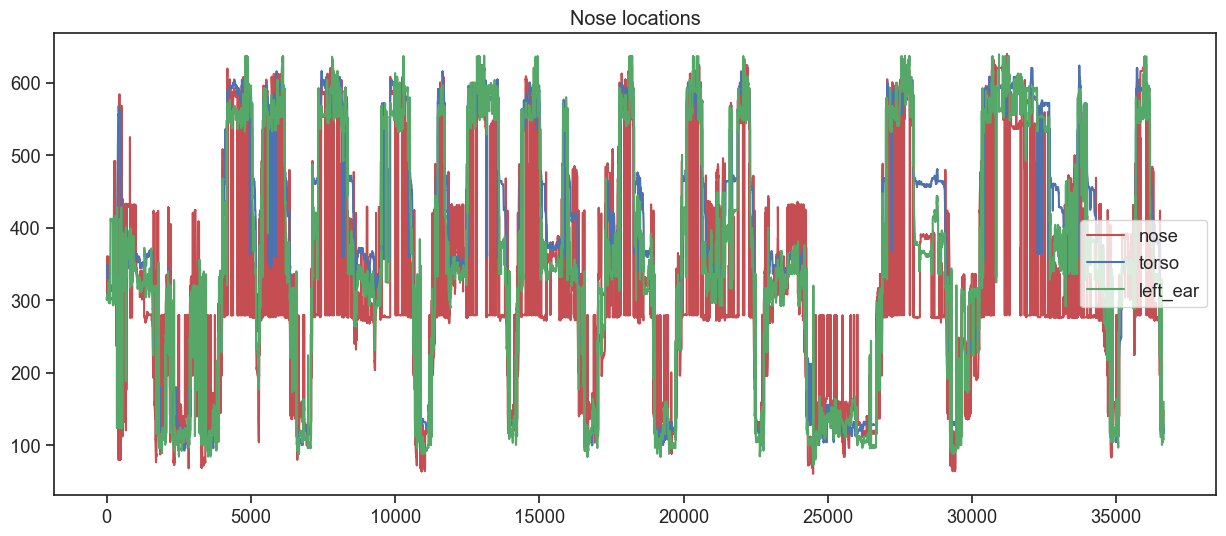

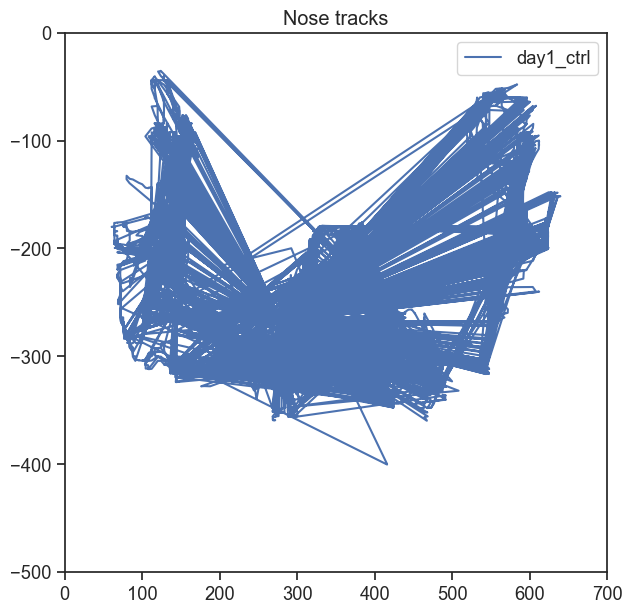

In [99]:
i = 1
plt.figure()
plt.plot(df['nose_x'].iloc[i], 'r',label='nose')
# plt.plot(-1*nose_loc[:,1,0], 'r')
plt.plot(df['torso_x'].iloc[i], 'b',label='torso')
plt.plot(df['leftear_x'].iloc[i], 'g',label='left_ear')
# plt.plot(rightear_loc[:,0,0], 'y',label='right_ear')

plt.legend(loc="center right")
plt.title('Nose locations')


plt.figure(figsize=(7,7))
plt.plot(df['nose_x'][i],-1*df['nose_y'][i], 'b',label='day1_ctrl')
plt.legend()

plt.xlim(0,700)
# plt.xticks([])

plt.ylim(-500,0)
#plt.yticks([])
plt.title('Nose tracks')

# color 250-450 as "interaction phase"

In [33]:

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [56]:
nose_loc = df['nose_x'].iloc[i],df['nose_y'].iloc[i]
nose_loc
# nose_vel = smooth_diff(nose_loc)
# torso_vel = smooth_diff(torso_loc[:,:,0])


(array([616.30926514, 616.23516846, 616.16644287, ..., 548.33862305,
        548.38433838, 551.83099365]),
 array([183.65576172, 183.72744751, 183.88682556, ..., 228.25134277,
        231.66029358, 232.25013733]))

Text(0.5, 1.0, 'Velocity')

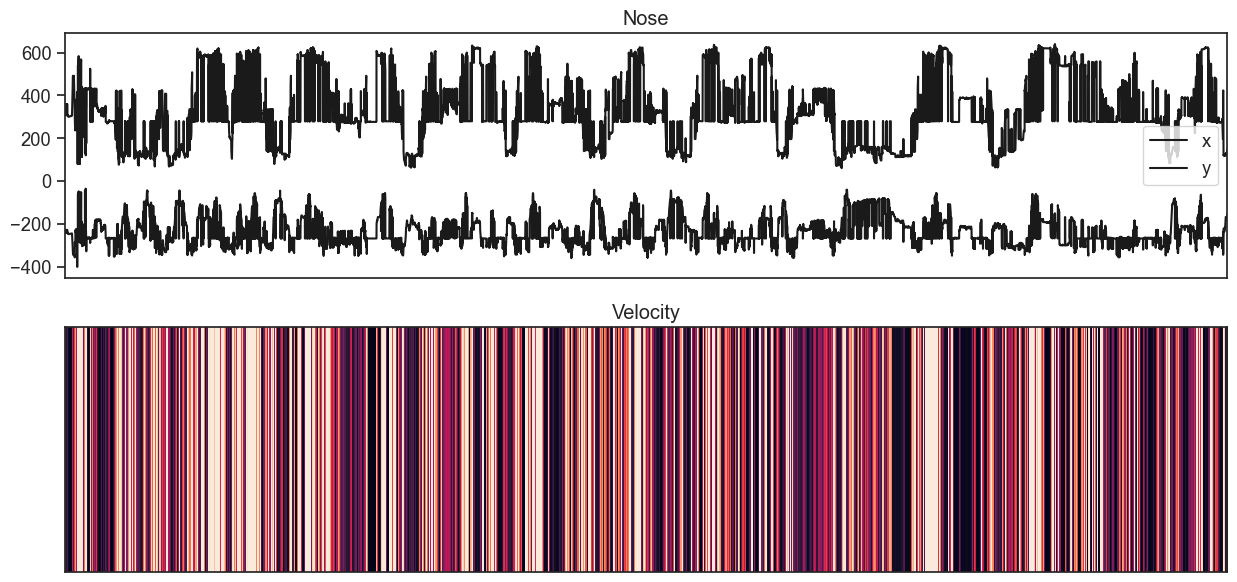

In [65]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(nose_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*nose_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Nose')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(nose_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Nose tracks colored by magnitude of animal speed')

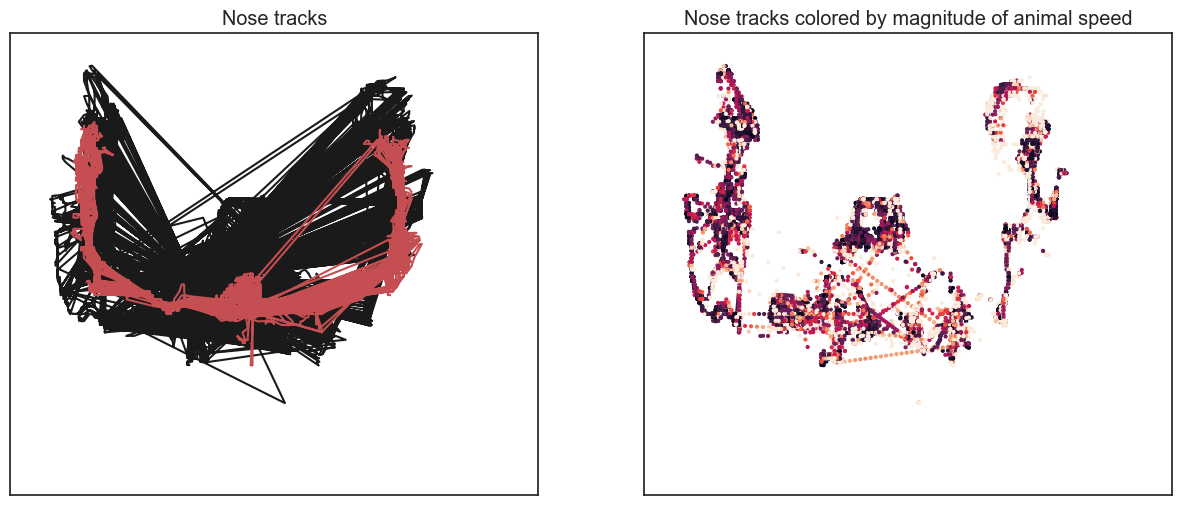

In [66]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(nose_loc[:, 0, 0], -1*nose_loc[:, 1, 0], 'k')
ax1.plot(torso_loc[:, 0, 0], -1*torso_loc[:, 1, 0], 'r')
ax1.set_xlim(0,800)
ax1.set_xticks([])
ax1.set_ylim(-500,0)
ax1.set_yticks([])
ax1.set_title('Nose tracks')

kp = nose_vel  
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(nose_loc[:,0,0], -1*nose_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)

ax2.set_xlim(0,800)
ax2.set_xticks([])
ax2.set_ylim(-500,0)
ax2.set_yticks([])
ax2.set_title('Nose tracks colored by magnitude of animal speed')


# lp = torso_vel
# ax3 = fig.add_subplot(120)
# ax3.scatter(torso_loc[:,0,0], -1*torso_loc[:,1,0], c=lp, s=4, vmin=vmin, vmax=vmax)

# ax3.set_xlim(0,800)
# ax3.set_xticks([])
# ax3.set_ylim(-500,0)
# ax3.set_yticks([])
# ax3.set_title('Torso tracks colored by magnitude of animal speed')

In [37]:
def instance_node_velocities(instance_idx):
    node_locations = locations[:, :, :, instance_idx]
    node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        node_velocities[:, n] = smooth_diff(node_locations[:, n, :])
    
    return node_velocities

In [38]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Animal {instance_idx} node velocities')

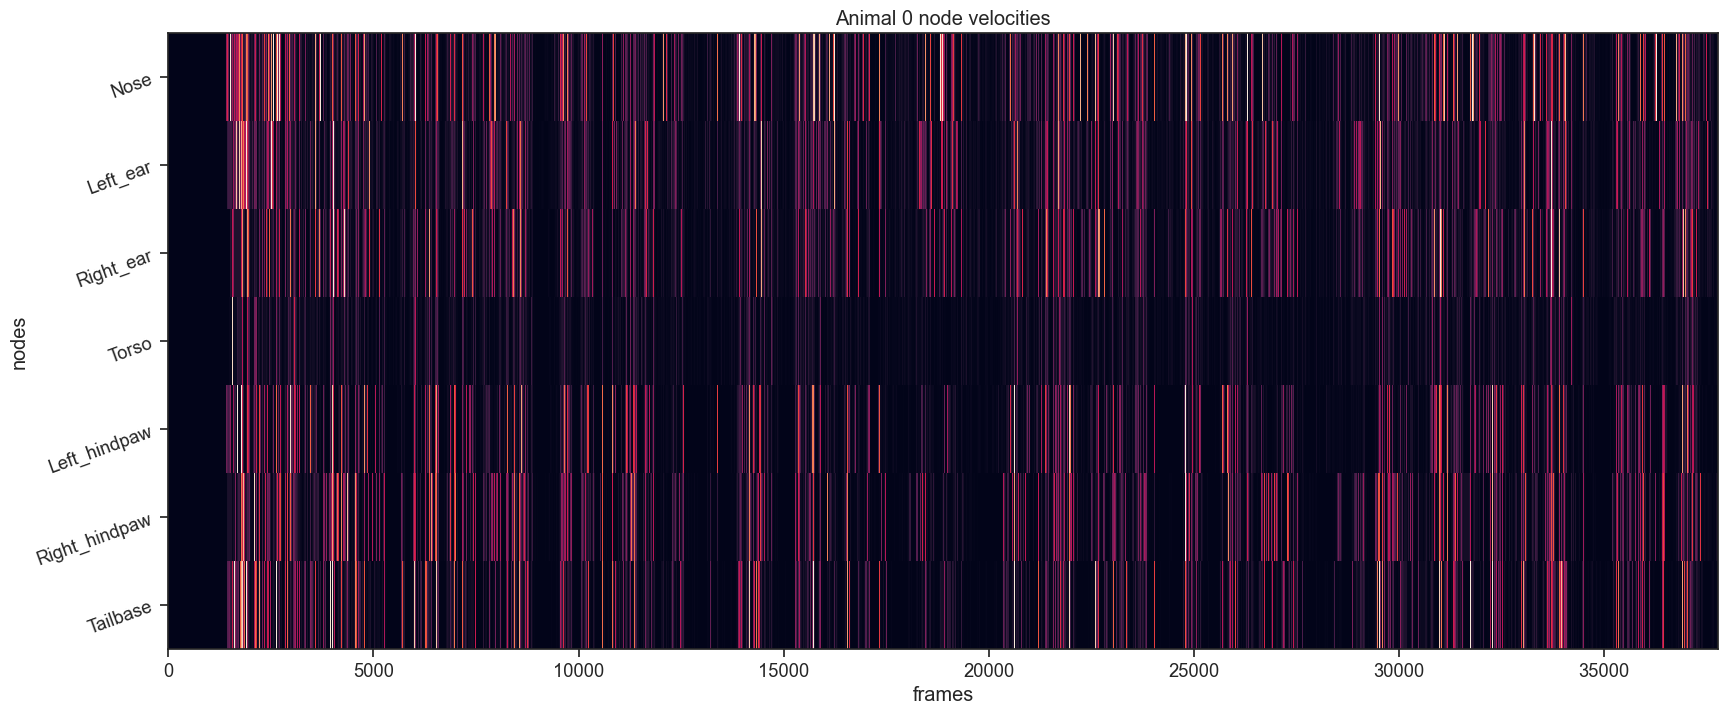

In [39]:
animal_ID = 0
node_velocities = instance_node_velocities(animal_ID)
plot_instance_node_velocities(animal_ID, node_velocities)